### **1. 모듈 준비**

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.5 MB/s eta 0:00:00


In [2]:
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob, pickle
import os
import warnings
warnings.filterwarnings("ignore")
# 경고메세지 생략, 오류메세지만 나오도록함.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Attention, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
import tensorflow_addons as tfa
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, BatchNormalization, Input, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import  multilabel_confusion_matrix, multilabel_confusion_matrix, log_loss
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve
from sklearn.preprocessing import Binarizer, minmax_scale

### **2. 분석준비**

* 음성 데이터 원본을 불러와 Mels와 MFCC 처리하는 과정을 생략하기 위해 전처리 결과를 pickle 형태로 저장함.

* 저장한 pickle 데이터를 불러온다.

**2.1. 음성 불러오기**

In [3]:
base_dir = "/content/drive/MyDrive/audio_project"
# 기본 direction 이동. 원래는 /content
os.chdir(base_dir)

# zipfile access
zip_access = zipfile.ZipFile('audio_data_all.zip','r')

name_list = zip_access.namelist()
# name_list 첫 번쨰 원소: '감정 분류 Mels, Mffc, Voice quality data/test_labels.pkl'

# 확장자별 파일 이름 분류
pkl_file = []
csv_file = []

for file_name in name_list:
    # 확장자 파일명확인
    ext_name = file_name.split('.')[-1]
    if ext_name == 'pkl':
        pkl_file.append(file_name)
    elif ext_name == 'csv':
        csv_file.append(file_name)

print(f"저장된 파일: \n{pkl_file}") # 저장된 파일 확인

저장된 파일: 
['감정 분류 Mels, Mffc, Voice quality data/test_labels.pkl', '감정 분류 Mels, Mffc, Voice quality data/test_labels_sets.pkl', '감정 분류 Mels, Mffc, Voice quality data/test_mels_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/test_mfcc_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_labels.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_labels_sets.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_mels_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_mfcc_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_labels.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_labels_sets.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_mels_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_mfcc_data.pkl']


**2.2. 데이터 형태 변경**
* 이미지로서 vit 모델에 사용할 수 있도록 channel dimension을 추가한다.

In [4]:
# VIT model의 경우 mels만 뽑는다.
idx = [0,1,2,4,5,6,8,9,10]
pkl_file = [pkl_file[idx] for idx in idx]

for pkl in pkl_file:
    with zip_access.open(pkl) as pickle_file:
        # 확장자 명을 제외한 부분을 변수명으로. ex) test_labels
        name = pkl.split('/')[-1].strip(".pkl")
        globals()["{}".format(name)] = pickle.load(pickle_file)

# channel 차원을 추가하는 함수
def img_data_trans(arr):
    arr = np.expand_dims(arr,-1)
    return arr

# train, test, val에 channel 차원을 추가한다.
X_train_vit, y_train = img_data_trans(train_mels_data), np.array(train_labels_sets)
X_test_vit, y_test = img_data_trans(test_mels_data), np.array(test_labels_sets)
X_val_vit, y_val = img_data_trans(val_mels_data), np.array(val_labels_sets)

print(f'X_train_vit shape: {X_train_vit.shape},y_train.shape: {y_train.shape}')
print(f'X_test_vit shape: {X_test_vit.shape}, y_test.shape: {y_test.shape}')
print(f'X_val_vit shape: {X_val_vit.shape}, y_val.shape: {y_val.shape}')

X_train_vit shape: (71340, 100, 300, 1),y_train.shape: (71340, 5)
X_test_vit shape: (12849, 100, 300, 1), y_test.shape: (12849, 5)
X_val_vit shape: (11968, 100, 300, 1), y_val.shape: (11968, 5)


**2.3. 파라미터 설정**

In [5]:
n_mels = 100
num_classes = 5
input_shape_vit = (100,300,1)
width_len = 5 # 300/(width_len) = 60이므로 100*5 patch가 60개 존재한다.
height_len = 100 # n_mels = height_len 직사각형으로 patch를 나눌 것이다.
patch_size = (height_len, width_len) # (100, 5)
num_patches = (input_shape_vit[1]//patch_size[1]) # 300//5 = 60

projection_dim = 64

transformer_units = [
    projection_dim * 2, # 2->3 크게 의미 없다.
    projection_dim]   # 마지막만 projection_dim이기만 하면됨.

transformer_layers = 6 # layer의 수가 6개 일 때가 적당했다.
mlp_head_units = [1024,512]
num_heads = 8 # 8개 일 때가 적당했다.

learning_rate = 0.0006
weight_decay = 0.0001
# learning rate이 0.0001일 때는 128, 0.001일 때는 256이 좋다.
batch_size = 256
num_epochs = 50

# 재현성을 위해 random seed를 고정한다.
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(42)

### **3. 모델 학습**
* 모델은 keras에서 제공하는 Vit model 코드를 참고하였다.

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]  # 입력 이미지의 배치 크기를 가져옴

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],  # 추출할 패치의 크기
            strides=[1, self.patch_size[0], self.patch_size[1], 1],  # 패치 윈도우의 이동 간격
            rates=[1, 1, 1, 1],  # 패치 추출 시 각 차원에서의 확장 비율
            padding="VALID",  # 패치가 이미지 안에 완전히 들어갈 수 있는 위치에서만 추출
        )

        # 현재 결과 (1,1,30,1000) -> 1000개의 값을 reshape해서 (100,10)으로 만들면 원래 이미지가 보인다.
        patch_dims = patches.shape[-1]  # 추출된 패치의 마지막 차원 크기를 가져옴

        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # 추출된 패치들을 2D 텐서로 변형.

        return patches  # 추출된 패치들을 반환

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
def create_vit_classifier(input_shape_vit, transformer_layers, num_heads, projection_dim, num_patches, transformer_units):
    inputs = layers.Input(shape=input_shape_vit)
    # 패치를 생성한다.
    patches = Patches(patch_size)(inputs)
    # patch를 projection dim 크리고 embedding하고 position정보를 학습하여 넣는다.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer block 생성.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(projection_dim//num_heads), dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.4)(representation)
    representation = layers.Dense(num_classes, activation = "sigmoid")(representation)
    return models.Model(inputs=inputs, outputs=representation)

In [8]:
model = create_vit_classifier(input_shape_vit, transformer_layers, num_heads, projection_dim, num_patches, transformer_units)

In [9]:
def run_experiment(model):
    # weight_decay: L2 정규화
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer, loss ='binary_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    # val데이터셋의 손실함수값을 최소화하는 것을 모니터링 하겠다. 멈추면 출력하겠다.(verbose) 성능이 향상되지 않아도 6걸음 나아가겠다.
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6, verbose =1, mode = 'min' )
    mc = ModelCheckpoint('best_model.hdf5', monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

    history = model.fit(X_train_vit, y_train,
                 validation_data=(X_val_vit, y_val),
                 epochs=num_epochs,
                 batch_size=batch_size,
                 callbacks=[earlystopping,mc])

    return history, model

history,model = run_experiment(model)

Epoch 1/50
278/279 [============================>.] - ETA: 0s - loss: 0.6704 - binary_accuracy: 0.6474
Epoch 1: val_binary_accuracy improved from -inf to 0.67396, saving model to best_model.hdf5
279/279 [==============================] - 28s 64ms/step - loss: 0.6703 - binary_accuracy: 0.6475 - val_loss: 0.6176 - val_binary_accuracy: 0.6740
Epoch 2/50
278/279 [============================>.] - ETA: 0s - loss: 0.6069 - binary_accuracy: 0.6829
Epoch 2: val_binary_accuracy improved from 0.67396 to 0.67447, saving model to best_model.hdf5
279/279 [==============================] - 14s 52ms/step - loss: 0.6069 - binary_accuracy: 0.6829 - val_loss: 0.6102 - val_binary_accuracy: 0.6745
Epoch 3/50
279/279 [==============================] - ETA: 0s - loss: 0.6012 - binary_accuracy: 0.6848
Epoch 3: val_binary_accuracy did not improve from 0.67447
279/279 [==============================] - 13s 46ms/step - loss: 0.6012 - binary_accuracy: 0.6848 - val_loss: 0.6123 - val_binary_accuracy: 0.6731
Epoch

### **4. 결과 확인**

In [10]:
def plot_history(history):

    plt.figure(figsize=(10 ,5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epcohs', weight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs', weight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 그래프 보이기
    plt.show()

def calculate_metrics(y_test, y_pred):
    label = ['happiness','sadness','angry','neutral','disgust']
    num_classes = 5
    accuracy = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    # sigmoid threshold에 맞게 값 변환

    # 저장되어 있는 주소 때문에 새로운 주소에 copy해야 원래 리스트가 변하지 않는다.
    cal_pred = y_pred.copy()
    cal_test = y_test.copy()

    for a in range(len(cal_pred)):
        for b in range(num_classes):
            if cal_pred[a][b] >= threshold_list[b]:
                cal_pred[a][b] = 1
            else:
                cal_pred[a][b] = 0

    for i in range(num_classes):
        true_positives = np.sum((cal_test[:, i] == 1) & (cal_pred[:, i] == 1))
        false_positives = np.sum((cal_test[:, i] == 0) & (cal_pred[:, i] == 1))
        false_negatives = np.sum((cal_test[:, i] == 1) & (cal_pred[:, i] == 0))
        true_negatives = np.sum((cal_test[:, i] == 0) & (cal_pred[:, i] == 0))
        accuracy[i] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-10)
        precision[i] = true_positives / (true_positives + false_positives + 1e-10)
        recall[i] = true_positives / (true_positives + false_negatives + 1e-10)
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)

        print(f"{label[i]} --- Accuracy: {accuracy[i]:.4f}, Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1_score[i]:.4f} \n")
    return cal_pred

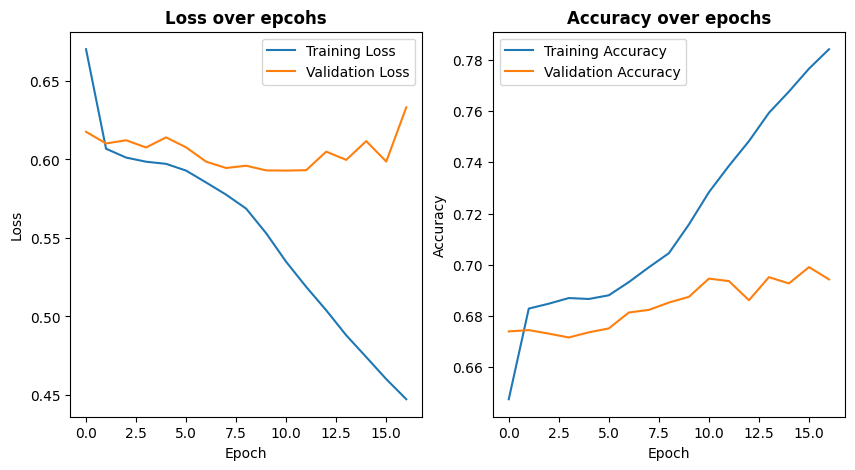

In [11]:
plot_history(history)

In [22]:
y_pred = model.predict(X_test_vit)

# label이 0인 경우가 1인 경우보다 많음. 불균형에 의해 예측값이 0에 가까워짐.
# threshold 값이 0.5보다 낮은게 더 설명력이 높음
print("\nthreshold값 0.4 통일")
threshold_list = [0.4,0.4,0.4,0.4,0.4]
cal_pred1 = calculate_metrics(y_test, y_pred) # calculated 된 pred

print("\nthreshold값 0.5 통일")
threshold_list = [0.5,0.5,0.5,0.5,0.5]
cal_pred2 = calculate_metrics(y_test, y_pred) # calculated 된 pred

402/402 [==============================] - 4s 9ms/step

threshold값 0.4 통일
happiness --- Accuracy: 0.7576, Precision: 0.5510, Recall: 0.5524, F1: 0.5517 

sadness --- Accuracy: 0.6463, Precision: 0.5661, Recall: 0.4512, F1: 0.5021 

angry --- Accuracy: 0.6797, Precision: 0.4778, Recall: 0.3877, F1: 0.4281 

neutral --- Accuracy: 0.6514, Precision: 0.5231, Recall: 0.6336, F1: 0.5731 

disgust --- Accuracy: 0.7478, Precision: 0.5352, Recall: 0.4383, F1: 0.4819 


threshold값 0.5 통일
happiness --- Accuracy: 0.7723, Precision: 0.5964, Recall: 0.4850, F1: 0.5350 

sadness --- Accuracy: 0.6528, Precision: 0.6149, Recall: 0.3260, F1: 0.4261 

angry --- Accuracy: 0.6900, Precision: 0.4970, Recall: 0.2273, F1: 0.3120 

neutral --- Accuracy: 0.6694, Precision: 0.5575, Recall: 0.5072, F1: 0.5311 

disgust --- Accuracy: 0.7573, Precision: 0.5764, Recall: 0.3502, F1: 0.4357 



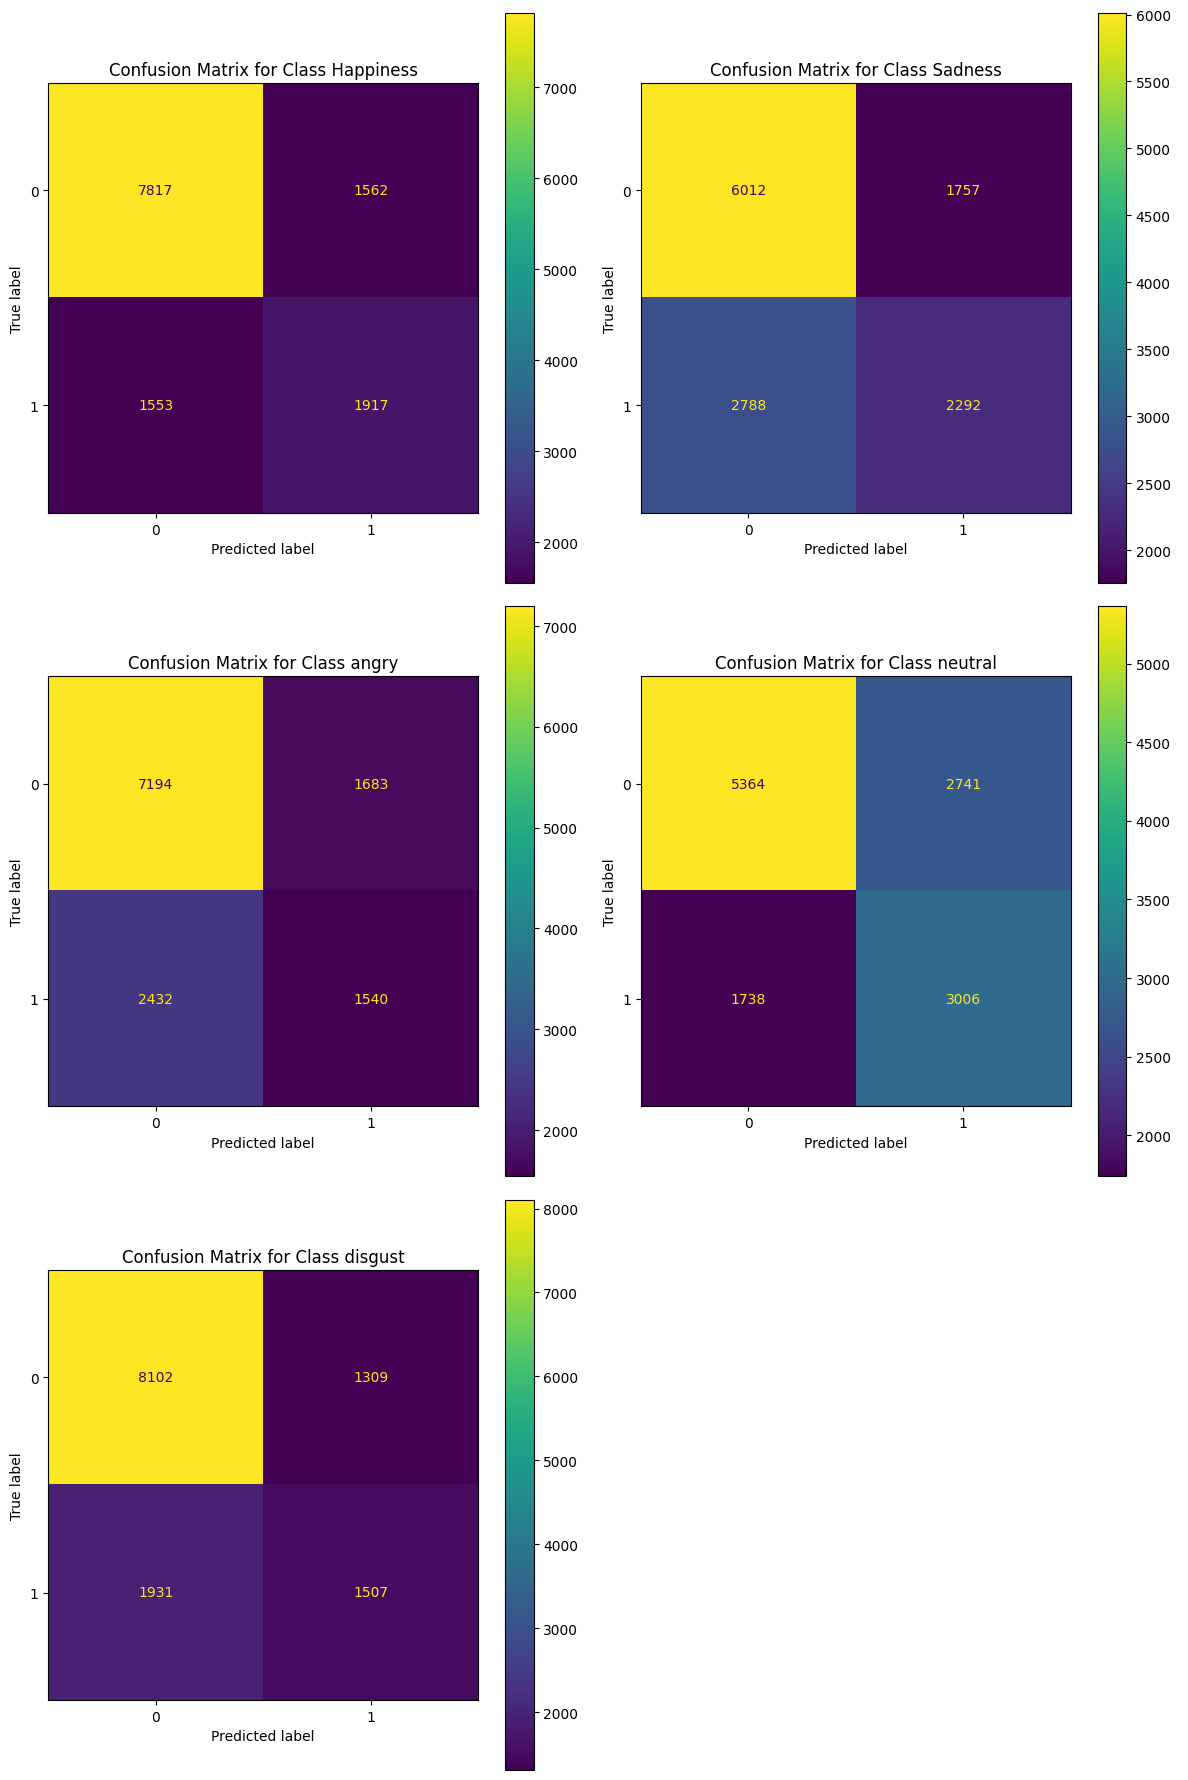

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_num = {0: "Happiness", 1: "Sadness", 2: "angry", 3: "neutral", 4: "disgust"}

# 일단 통일성을 위해 thres 0.4인 경우 실행결과 값의 confusion matrix를 확인
custom_y_test = cal_pred1.copy()
num_classes = 5

fig, axes = plt.subplots(3, 2, figsize = (12,18))

for class_idx in range(num_classes):
    class_true = y_test[:, class_idx]
    class_pred = custom_y_test[:, class_idx]

    # 혼동 행렬 계산
    cm = confusion_matrix(class_true, class_pred)

    # subplot 인덱스 계산(열로 나누면 )
    row_idx = class_idx // 2
    col_idx = class_idx % 2

    # 혼동 행렬 플롯
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)

    # 플롯 설정

    axes[row_idx, col_idx].set_title(f'Confusion Matrix for Class {label_num[class_idx]}')
    axes[row_idx, col_idx].set_xlabel('Predicted Label')
    axes[row_idx, col_idx].set_ylabel('True Label')
    disp.plot(ax = axes[row_idx, col_idx])
    axes[row_idx, col_idx].grid(False)

axes[2, 1].axis('off') # 나머지인 3행 2열 axes는 정보가 없으므로 끈다. (2,1)인 이유는 시작 idx가 0이기에 그렇다.
plt.tight_layout()
plt.show()

In [41]:
accuracy = accuracy_score(y_test, cal_pred1)
print(f"0.4일때 accuarcy 값: {accuracy}") # 정확히 맞춘경우

def trans_to_series(pred_list):
    return pd.Series(["".join(list(map(str,map(int, i)))) for i in pred_list]).value_counts()

cal_pred1 = pd.DataFrame(trans_to_series(cal_pred1)).reset_index()
cal_pred2 = pd.DataFrame(trans_to_series(cal_pred2)).reset_index()
answer = pd.DataFrame(trans_to_series(y_test)).reset_index()


agg_df = pd.merge(cal_pred1, cal_pred2, right_on = "index", left_on = "index", how = "outer")
agg_df = pd.merge(agg_df, answer, right_on = "index", left_on = "index", how = "outer")
agg_df.columns = ["index", "pred_0.4","pred_0.5","answer"]
agg_df.fillna(0, inplace = True)
agg_df.iloc[:,1:] = agg_df.iloc[:,1:].astype("int")
print(agg_df)

0.4일때 accuarcy 값: 0.20460736244065686
    index  pred_0.4  pred_0.5  answer
0   00010      2089      2662    1069
1   10010      1399       933    1114
2   01000      1357      1354    1013
3   10000       897      1278    1039
4   11000       863       556    1317
5   00110       820       314     799
6   00000       816      2615       0
7   00101       792       514    1085
8   00100       703       762    1106
9   01001       642       472     796
10  00001       510       820     767
11  01010       470       131     972
12  00111       368        76       0
13  00011       331       171     790
14  01100       313       111     982
15  11010       189        27       0
16  01101       110        23       0
17  01110        45         2       0
18  11100        37        13       0
19  10001        30         9       0
20  10110        20         0       0
21  11001        18         4       0
22  10100        14         2       0
23  10011        11         0       0
24  01011   

* 단일 감정의 정확도가 높지 않았기에 전체를 모두 맞춘 경우는 적은 것을 볼 수 있다.
* threshold 값을 낮추었을때 다양하게 감정을 예측함을 볼 수 있다.
* training loss가 validation loss보다 현저하게 낫기에 overfitting이 발생했음을 볼 수 있다. 하지만 모델을 단순하게 만들경우 validation loss가 작아지고 전체 성능도 줄어든다. 모델의 복잡도 문제보다는 양질의 데이터 부족이 원인으로 보인다.